## Lower metabolite levels in segregants?

Transgressive segregation analysis suggested that metabolite levels are universally lower in the segregants compared to the parents.

Is this true?

**Conclusion**: Metabolite levels are nearly universally lower in segregregants compared to both of the parental strains (26 out of 27 metabolites measured in both parentals and segregants)

In [24]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(parallel);
options(mc.cores = 24);
library(stringr);
library(RColorBrewer);

In [25]:
# load parental data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

endometabolite = endometabolite %>% filter(time_format == "absolute")

In [26]:
#head(parents)

In [27]:
#head(endometabolite)

In [28]:
combined_data = endometabolite %>% group_by(metabolite) %>% do({
    thismetabolite = levels(.$metabolite)[.$metabolite[1]]
    df1 = data.frame(metabolite = thismetabolite, 
                     value.log2 = .$value.log2, 
                     time = .$time, source = "segregant", stringsAsFactors = F)
    parent_sub = parents %>% filter(metabolite == thismetabolite)
    if (dim(parent_sub)[1] > 0) {
        df2 = data.frame(metabolite = thismetabolite, 
                     value.log2 = parent_sub$endo_quant_log, 
                     time = parent_sub$time, source = "parent", stringsAsFactors = F)
    } else {
        df2 = data.frame()
    }
    df1$time = df1$time
    df2$time = as.numeric(levels(df2$time)[df2$time])
    return(rbind(df1,df2))
})

### Simple t-test

#### Across all metabolites and timepoints

In [32]:
s_d = combined_data %>% filter(source == "segregant")
p_d = combined_data %>% filter(source == "parent")
t.test(s_d$value.log2, 
       p_d$value.log2)


	Welch Two Sample t-test

data:  s_d$value.log2 and p_d$value.log2
t = -11.652, df = 1651.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0353066 -0.7369704
sample estimates:
mean of x mean of y 
 9.664803 10.550941 


**RESULT**: Mean level of all metabolites, timepoints, and replicates is lower in the segregants compared to the parents

#### Per timepoint

In [49]:
per_m_ttest = combined_data %>% group_by(metabolite) %>%
    do({
        #print(head(.))
        #s_d = . %>% filter(source == "segregant")
        s_d = .[.$source=="segregant",]
        #p_d = . %>% filter(source == "parent")
        p_d = .[.$source=="parent",]
        #print(head(s_d))
        pval = try({t.test(s_d$value.log2, 
               p_d$value.log2)$p.value})
        if (!class(pval)=="try-error") {
            return(data.frame(pval))
        } else {
            return(data.frame())
        }
    })
per_m_ttest$pval = p.adjust(per_m_ttest$pval, method="BH")
sigM = sum(per_m_ttest$pval <= 0.05)
cat(sigM, "out of", length(per_m_ttest$pval), 
    "metabolite levels are significantly lower in segregants compared to parental strains")

26 out of 27 metabolite levels are significantly lower in segregants compared to parental strains

**RESULT**: Mean level of each metabolite (all timepoints and replicates) is lower in the segregants compared to the parents

### Visualization

Warning message:
: Removed 6603 rows containing non-finite values (stat_boxplot).

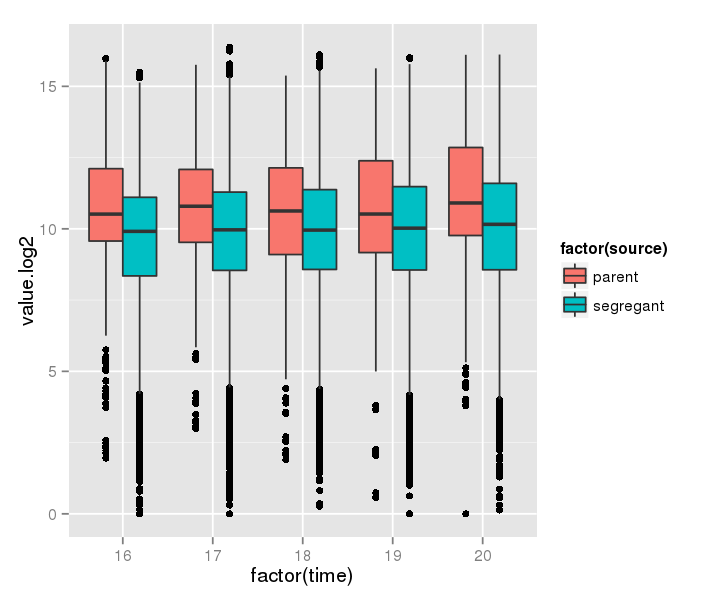

In [10]:
p <- ggplot(combined_data, aes(factor(time), value.log2))
p + geom_boxplot(aes(fill=factor(source))) 

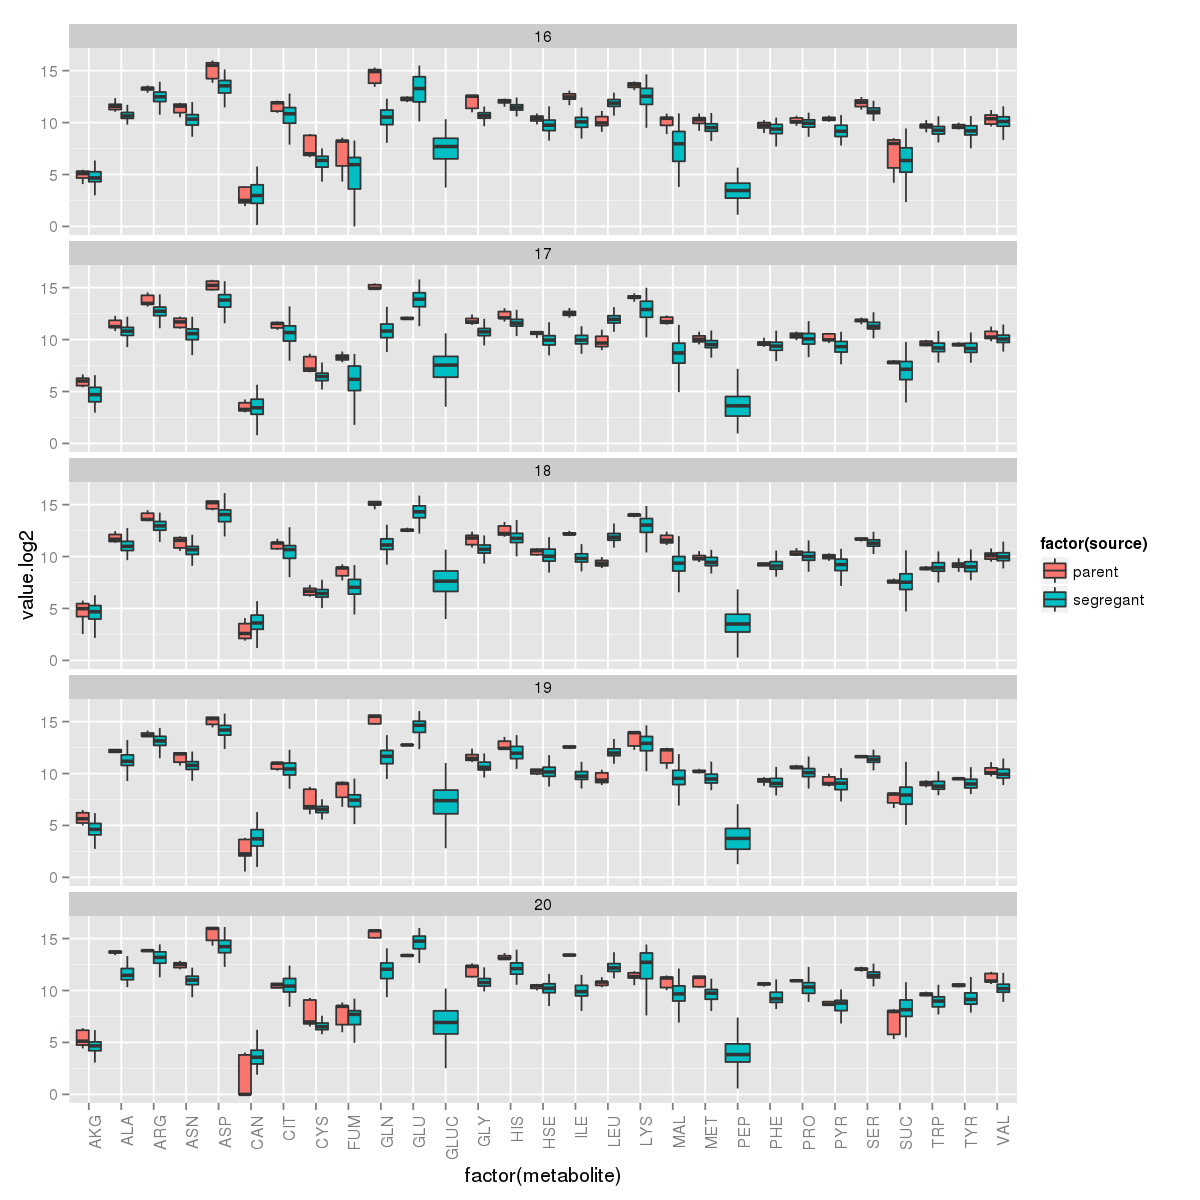

In [20]:
options(repr.plot.width = 10)
options(repr.plot.height = 10)
p <- ggplot(combined_data, aes(factor(metabolite), value.log2))
p + geom_boxplot(aes(fill=factor(source)),na.rm=T, outlier.size = 0) + 
    facet_wrap(~time, ncol = 1) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))